In [79]:
from datasets import Dataset, DatasetDict
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForTokenClassification
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer

## Helper functions and declarations

In [2]:
label_names = ['O', 'B-ART','I-ART','B-CON','I-CON','B-LOC','I-LOC',
        'B-MAT','I-MAT','B-PER','I-PER','B-SPE','I-SPE']
id2label = {i: l for i, l in enumerate(label_names)}
label2id = {l: i for i, l in id2label.items()}

In [3]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], truncation=True, is_split_into_words=True
    )
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }


def parse(sentence):
    tokens, ner_tags = [], []
    for phrase in sentence:
            features = phrase.split(' ')
            tokens.append(features[0].strip())
            ner_tags.append(label2id[features[2].strip()])
    return {'tokens': tokens, 'ner_tags': ner_tags}

## Data Loading

In [4]:
raw_datasets = {}
for split in ('train', 'val', 'test'):
    raw_datasets[split] = {}
    with open(f'{split}.txt', 'r') as infile:
        raw_data = infile.read()
        lines = raw_data.split('\n')
        sentences = raw_data.split('\n\n')
        sentences = [parse(sentence.split('\n')) for sentence in sentences]
        for sentence in sentences:
            for k in sentence:
                if k not in raw_datasets[split].keys():
                    raw_datasets[split][k] = []
                raw_datasets[split][k].append(sentence[k])


datasets = {}
for split in raw_datasets.keys():
    datasets[split] = Dataset.from_dict(raw_datasets[split])
data = DatasetDict(datasets)

### Data statistics

In [84]:
ner = data['train']['ner_tags']
ner += data['test']['ner_tags']
ner += data['val']['ner_tags']
ner = np.array([tag for taglist in ner for tag in taglist])

In [171]:
ner_df = pd.DataFrame(ner, columns=['ner_tag'])
ner_df['ner_label'] = ner_df['ner_tag'].map(id2label)
ner_df.loc[ner_df['ner_label'] != 'O','ner_label_grouped'] = \
    ner_df.loc[ner_df['ner_label'] != 'O','ner_label'].apply(
        lambda x: x.split('-')[1])
ner_df['ner_label_grouped'] = ner_df['ner_label_grouped'].fillna('O')
ner_df_counts = ner_df.groupby(
    ['ner_label_grouped', 'ner_label']
)['ner_label'].count().to_frame().drop('O')
ner_df_counts.columns = ['counts']

In [177]:
ner_df_counts.sort_values(by='counts', ascending=False).sort_index(level=0)

counts
ner_label_grouped ner_label        
ART               B-ART        1420
                  I-ART         498
CON               B-CON        1374
                  I-CON         278
LOC               B-LOC         635
                  I-LOC         670
MAT               B-MAT         249
                  I-MAT          39
PER               B-PER        1833
                  I-PER        1493
SPE               B-SPE         154
                  I-SPE          23

Index(['ART', 'CON', 'LOC', 'MAT', 'PER', 'SPE'], dtype='object', name='ner_label_grouped')

In [128]:
ner_df_counts.groupby(level=[0]).sum().values.flatten()

array([1918, 1652, 1305,  288, 3326,  177])

In [158]:
ner_df_counts

ner_label
ner_label_grouped ner_label           
ART               B-ART           1420
                  I-ART            498
CON               B-CON           1374
                  I-CON            278
LOC               B-LOC            635
                  I-LOC            670
MAT               B-MAT            249
                  I-MAT             39
PER               B-PER           1833
                  I-PER           1493
SPE               B-SPE            154
                  I-SPE             23

In [181]:
ner_df_counts.index.get_level_values(0).drop_duplicates()

Index(['ART', 'CON', 'LOC', 'MAT', 'PER', 'SPE'], dtype='object', name='ner_label_grouped')

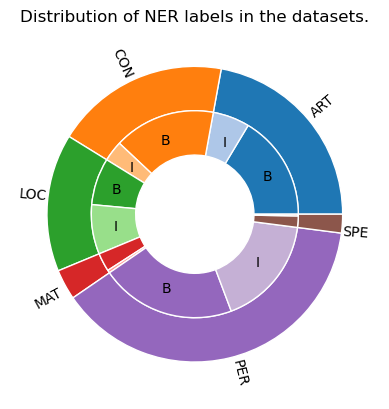

In [ ]:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20"]
size=0.3
outer_colors = cmap(np.arange(6)*2)
inner_colors = cmap(np.arange(12))
textprops = {'color': 'k'}
startangle = 0

outer_labels = ner_df_counts.index.get_level_values(0).drop_duplicates()
wedges, texts = ax.pie(
    ner_df_counts.groupby(level=[0]).sum().values.flatten(),
    labels=outer_labels,
    radius=1, colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labeldistance=1,
    rotatelabels=True,
    textprops=textprops,
    startangle=startangle)

inner_labels = [i.split('-')[0] 
                for i in ner_df_counts.index.get_level_values(1).to_list()]

inner_labels[-2:] = [''] * 2
inner_labels[6:8] = [''] * 2
ax.pie(ner_df_counts.values.flatten(),
       labels=inner_labels,
       radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'),
       labeldistance=0.75,
       textprops=textprops,
       startangle=startangle)

ax.set_title('Distribution of NER labels in the datasets.')
plt.show()

In [42]:
ner_idx, ner_counts = np.unique(ner[ner != 0], return_counts=True)
sorted_idx = np.argsort(ner_counts,)[::-1]
ner_idx = ner_idx[sorted_idx]
ner_counts = ner_counts[sorted_idx]

In [64]:
ner2 = ner[ner != 0]
ner2[np.where(ner2 % 2 == 0)] = ner2[np.where(ner2 % 2 == 0)] - 1

In [65]:
ner_idx2, ner_counts2 = np.unique(ner2, return_counts=True)
sorted_idx2 = np.argsort(ner_counts2)[::-1]
ner_idx2 = ner_idx2[sorted_idx2]
ner_counts2 = ner_counts2[sorted_idx2]

In [78]:
ner_idx

array([ 9, 10,  1,  3,  6,  5,  2,  4,  7, 11,  8, 12])

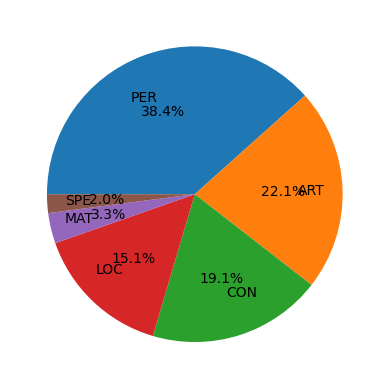

In [75]:
labels = [id2label[i] for i in ner_idx2]
labels = [label.split('-')[1] for label in labels]
plt.pie(ner_counts2, 
        labels=labels,
        labeldistance=0.7,
        startangle=180,
        autopct='%1.1f%%',
        counterclock=False)
plt.show()

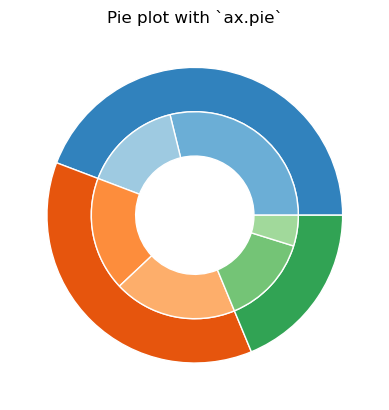

In [76]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.colormaps["tab20c"]
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

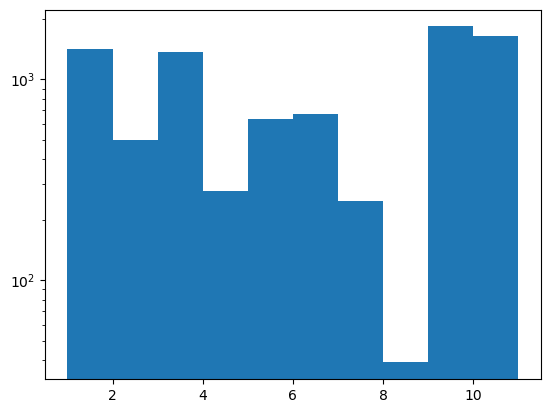

In [75]:
plt.hist(ner_nonO, bins=np.arange(1, 12))
plt.yscale('log')

## Preprocessing

### Tokenization and alignment

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

data_tokenized = data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=data['train'].column_names)

Map:   0%|          | 0/1992 [00:00<?, ? examples/s]

Map:   0%|          | 0/850 [00:00<?, ? examples/s]

Map:   0%|          | 0/864 [00:00<?, ? examples/s]

## Training

### Training set-up

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load('seqeval')

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

args = TrainingArguments(
    "bert-finetuned-archeology",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Training loop

In [34]:
trainer.train()
trainer.push_to_hub(commit_message="Training complete")

  0%|          | 0/747 [00:00<?, ?it/s]

{'eval_loss': 0.21270084381103516, 'eval_precision': 0.499194847020934, 'eval_recall': 0.6378600823045267, 'eval_f1': 0.5600722673893406, 'eval_accuracy': 0.9467969124765601, 'eval_runtime': 11.5379, 'eval_samples_per_second': 73.67, 'eval_steps_per_second': 9.274, 'epoch': 1.0}


  0%|          | 0/107 [00:00<?, ?it/s]

{'eval_loss': 0.2322877198457718, 'eval_precision': 0.5253968253968254, 'eval_recall': 0.6810699588477366, 'eval_f1': 0.5931899641577061, 'eval_accuracy': 0.9476690942392395, 'eval_runtime': 12.3934, 'eval_samples_per_second': 68.585, 'eval_steps_per_second': 8.634, 'epoch': 2.0}
{'loss': 0.0737, 'grad_norm': 0.9115849137306213, 'learning_rate': 6.6131191432396255e-06, 'epoch': 2.01}


  0%|          | 0/107 [00:00<?, ?it/s]

{'eval_loss': 0.2524833381175995, 'eval_precision': 0.5037537537537538, 'eval_recall': 0.6903292181069959, 'eval_f1': 0.5824652777777778, 'eval_accuracy': 0.9453142034800053, 'eval_runtime': 11.5912, 'eval_samples_per_second': 73.331, 'eval_steps_per_second': 9.231, 'epoch': 3.0}
{'train_runtime': 626.9456, 'train_samples_per_second': 9.532, 'train_steps_per_second': 1.191, 'train_loss': 0.06035551584389315, 'epoch': 3.0}


events.out.tfevents.1730815554.Jans-MacBook-Pro-2.local.3581.0:   0%|          | 0.00/12.9k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/janzuromski/bert-finetuned-archeology/commit/1656eb825c37e4fc19604b11d726843bb4799f6c', commit_message='Training complete', commit_description='', oid='1656eb825c37e4fc19604b11d726843bb4799f6c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/janzuromski/bert-finetuned-archeology', endpoint='https://huggingface.co', repo_type='model', repo_id='janzuromski/bert-finetuned-archeology'), pr_revision=None, pr_num=None)